# Introduction to Graph Neural Networks

Introduction to Graph Neural Networks and Graph Algorithms
Graphs are a powerful data structure used to represent relationships between entities. In a graph, nodes (or vertices) represent entities, and edges represent the connections or interactions between them. Graphs are prevalent in a wide range of domains such as social networks, biological networks, recommendation systems, and transportation systems.

Graph algorithms are traditional computational methods designed to analyze and extract information from graphs. These include well-known techniques like Dijkstra’s algorithm for shortest paths, PageRank for ranking nodes, and depth-first or breadth-first search for traversing graphs. These algorithms help solve problems such as network connectivity, community detection, and influence propagation.

Graph Neural Networks (GNNs) are a modern approach that applies deep learning to graph-structured data. Unlike traditional neural networks, GNNs can model the dependencies between nodes by aggregating and transforming information from a node’s neighbors. This allows GNNs to learn representations that capture both node features and graph topology, enabling tasks like node classification, link prediction, and graph classification.

Together, graph algorithms and GNNs offer complementary approaches for understanding complex relational data, combining the rigor of classical methods with the adaptability of machine learning.

# Brief History of Graph Neural Networks


### Timeline of Graph Neural Networks (GNNs)

- **2005 – Early Foundations**  
  *Scarselli et al.* propose the first concept of Graph Neural Networks, introducing the idea of using neural networks to operate over graph-structured data. This laid the theoretical groundwork but was limited in scalability and practical adoption.

- **2013 – Spectral Approaches**  
  *Bruna et al.* apply convolutional neural networks to graphs using spectral methods from graph signal processing, initiating the field of graph-based deep learning.

- **2016 – Graph Convolutional Networks (GCNs)**  
  *Thomas Kipf and Max Welling* introduce GCNs, a simplified and scalable layer-wise propagation rule for semi-supervised learning on graphs. This model becomes the foundation for many future GNN variants.

- **2017 – GraphSAGE**  
  *Hamilton et al.* propose GraphSAGE, a method that learns aggregation functions for node embeddings and allows for inductive learning—critical for generalizing to unseen nodes.

- **2018 – GAT (Graph Attention Networks)**  
  *Velickovic et al.* introduce attention mechanisms into GNNs, enabling nodes to assign different importance to neighbors during message passing, improving performance on heterogeneous graphs.

- **2019 – GNN Applications Boom**  
  GNNs start seeing widespread use in areas like recommendation systems, protein structure prediction, social network analysis, and fraud detection.

- **2020s – Scalability and Expressiveness**  
  Advances like **Graph Isomorphism Networks (GINs)** improve the theoretical expressiveness of GNNs, while **scalable GNN frameworks** (e.g., GraphSAINT, Cluster-GCN) address training on large-scale graphs.

- **2022–2023 – Beyond Node Classification**  
  GNNs begin to excel in tasks like **graph-level prediction**, **spatiotemporal forecasting**, and **molecular property prediction** (e.g., AlphaFold using GNN-like architecture for protein folding).

- **2024 – Integration with LLMs and Multimodal AI**  
  Emerging research explores combining GNNs with large language models (LLMs) and other modalities to enhance reasoning over structured knowledge and multimodal data.



# Data Overview

In [1]:
from torch.serialization import add_safe_globals
from torch_geometric.data import Data

safe_classes = [Data]

# Optional: only add DataEdgeAttr if it exists in your PyG version
try:
    from torch_geometric.data.storage import DataEdgeAttr
    safe_classes.append(DataEdgeAttr)
except ImportError:
    pass  # You're likely using a PyG version that doesn't need it

add_safe_globals(safe_classes)



In [2]:
import torch
_orig_load = torch.load
def patched_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _orig_load(*args, **kwargs)
torch.load = patched_load


In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import GATv2Conv, GCNConv

from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import SNAPDataset
import networkx as nx


from torch.nn import Linear, Dropout

from torch_geometric.utils import degree
from collections import Counter
import numpy as np



In [4]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset_cora = Planetoid(root=".", name="Cora")

data_cora = dataset_cora[0]

# Print information about the dataset
print(f'Dataset: {dataset_cora}')
print('---------------')
print(f'Number of graphs: {len(dataset_cora)}')
print(f'Number of nodes: {data_cora.x.shape[0]}')
print(f'Number of features: {dataset_cora.num_features}')
print(f'Number of classes: {dataset_cora.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data_cora.is_directed()}')
print(f'Graph has isolated nodes: {data_cora.has_isolated_nodes()}')
print(f'Graph has loops: {data_cora.has_self_loops()}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Processing...
Done!


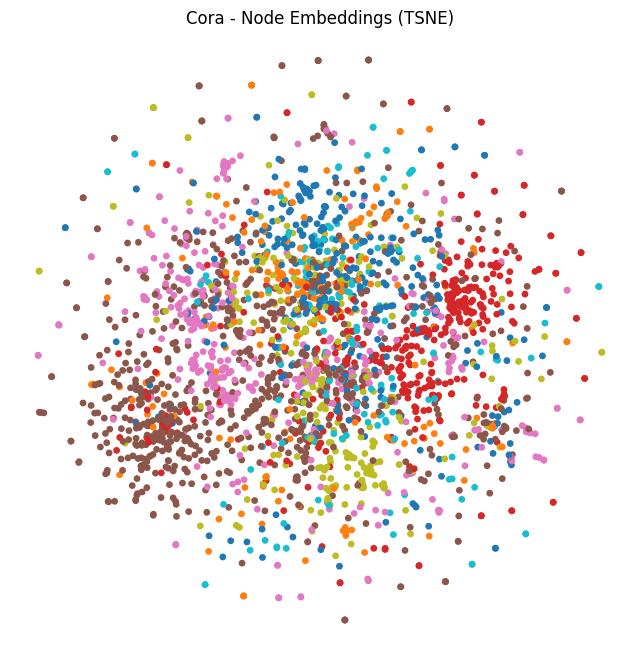

In [19]:
# Convert to NetworkX for visualization
G = to_networkx(data_cora, to_undirected=True)

# Reduce dimensions
tsne = TSNE(n_components=2)
node_pos = tsne.fit_transform(data_cora.x.cpu())

# Plot nodes with colors based on labels
plt.figure(figsize=(8, 8))
plt.scatter(node_pos[:, 0], node_pos[:, 1], c=data_cora.y.cpu(), cmap='tab10', s=15)
plt.title("Cora - Node Embeddings (TSNE)")
plt.axis('off')
plt.show()

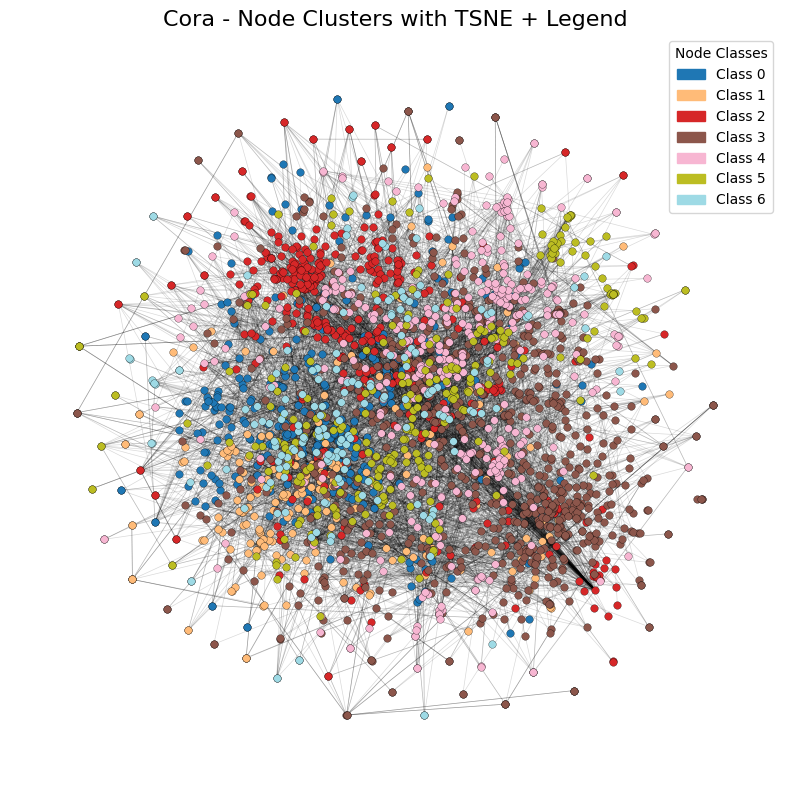

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from matplotlib import colormaps

cmap = colormaps.get_cmap('tab20').resampled(7)


# 1. Convert to undirected NetworkX graph
G = to_networkx(data_cora, to_undirected=True)

# 2. TSNE on node features
tsne = TSNE(n_components=2, random_state=42)
pos = tsne.fit_transform(data_cora.x.cpu())
pos_dict = {i: pos[i] for i in range(len(pos))}

# 3. Get class labels
labels = data_cora.y.cpu().numpy()
num_classes = labels.max() + 1

# 4. Plot with per-class coloring
plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos=pos_dict, alpha=0.15, width=0.5)

handles = []
for class_id in range(num_classes):
    idx = [i for i in range(len(labels)) if labels[i] == class_id]
    node_color = cmap(class_id)
    nx.draw_networkx_nodes(G, pos=pos_dict, nodelist=idx,
                           node_color=[node_color],
                           node_size=30,
                           edgecolors='k',
                           linewidths=0.2)
    handles.append(mpatches.Patch(color=node_color, label=f"Class {class_id}"))

plt.legend(handles=handles, title="Node Classes", loc='upper right', fontsize=10)
plt.title("Cora - Node Clusters with TSNE + Legend", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [21]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset_fb = FacebookPagePage(root=".")

data_fb = dataset_fb[0]

# Print information about the dataset
print(f'Dataset: {dataset_fb}')
print('-----------------------')
print(f'Number of graphs: {len(dataset_fb)}')
print(f'Number of nodes: {data_fb.x.shape[0]}')
print(f'Number of features: {dataset_fb.num_features}')
print(f'Number of classes: {dataset_fb.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data_fb.is_directed()}')
print(f'Graph has isolated nodes: {data_fb.has_isolated_nodes()}')
print(f'Graph has loops: {data_fb.has_self_loops()}')

# Create masks
data_fb.train_mask = range(18000)
data_fb.val_mask = range(18001, 20000)
data_fb.test_mask = range(20001, 22470)

Dataset: FacebookPagePage()
-----------------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


In [22]:
# import shutil
# shutil.rmtree('/tmp/Reddit', ignore_errors=True)


In [23]:
from torch_geometric.datasets import Reddit

dataset_re = Reddit(root='/tmp/Reddit')
data_re = dataset_re[0]

# Print information about the dataset
print(f'Dataset: {dataset_re}')
print('-----------------------')
print(f'Number of graphs: {len(dataset_re)}')
print(f'Number of nodes: {data_re.x.shape[0]}')
print(f'Number of features: {dataset_re.num_features}')
print(f'Number of classes: {dataset_re.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data_re.is_directed()}')
print(f'Graph has isolated nodes: {data_re.has_isolated_nodes()}')
print(f'Graph has loops: {data_re.has_self_loops()}')

# Create masks
data_re.train_mask = range(18000)
data_re.val_mask = range(18001, 20000)
data_re.test_mask = range(20001, 22470)

Dataset: Reddit()
-----------------------
Number of graphs: 1
Number of nodes: 232965
Number of features: 602
Number of classes: 41

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [24]:
# G = to_networkx(data_fb, to_undirected=True)

# Use spring layout for structure visualization
# pos = nx.spring_layout(G, seed=42)

# plt.figure(figsize=(10, 8))
# nx.draw(G, pos, node_size=10, edge_color='gray', alpha=0.3, with_labels=False)
# plt.title("Facebook Page-Page Graph")
# plt.show()

# Vanilla GNN


Assumes every node has a consistant number of neighbors which is rarely the case.  Vanilla uses a linear layer which doesn't weight neighbors consistantly and can lead to poor results

In [25]:
# def get_adjacency(dataset):
    # adjacency = to_dense_adj(dataset.edge_index)[0]
    # adjacency += torch.eye(adjacency.size(0), device=adjacency.device)
    # return adjacency

In [26]:
def get_adjacency(dataset):
    edge_index = dataset.edge_index
    num_nodes = dataset.num_nodes
    edge_weight = torch.ones(edge_index.shape[1], device=edge_index.device)

    # Sparse adjacency
    adj = torch.sparse_coo_tensor(edge_index, edge_weight, (num_nodes, num_nodes))

    # Add self-loops
    self_loops = torch.arange(num_nodes, device=edge_index.device)
    loop_index = torch.stack([self_loops, self_loops])
    loop_weight = torch.ones(num_nodes, device=edge_index.device)

    adj += torch.sparse_coo_tensor(loop_index, loop_weight, (num_nodes, num_nodes))
    return adj.coalesce()

In [27]:
adjacency = get_adjacency(data_cora)

In [28]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)
    
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [29]:
class VanillaGNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc


In [30]:
# Create the Vanilla GNN model
gnn = VanillaGNN(dataset_cora.num_features, 16, dataset_cora.num_classes)
print(gnn)

# Train
gnn.fit(data_cora, epochs=100)

# Test
acc = gnn.test(data_cora)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)
Epoch   0 | Train Loss: 2.039 | Train Acc: 16.43% | Val Loss: 2.10 | Val Acc: 8.80%
Epoch  20 | Train Loss: 0.025 | Train Acc: 100.00% | Val Loss: 2.20 | Val Acc: 74.40%
Epoch  40 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 2.95 | Val Acc: 73.20%
Epoch  60 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 3.04 | Val Acc: 73.80%
Epoch  80 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 2.96 | Val Acc: 74.20%
Epoch 100 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 2.89 | Val Acc: 74.40%

GNN test accuracy: 75.10%


In [31]:
adjacency = get_adjacency(data_fb)

In [32]:
# Create the Vanilla GNN model
gnn = VanillaGNN(dataset_fb.num_features, 16, dataset_fb.num_classes)
print(gnn)

# Train
gnn.fit(data_fb, epochs=100)

# Test
acc = gnn.test(data_fb)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 97.323 | Train Acc: 32.08% | Val Loss: 86.37 | Val Acc: 33.17%
Epoch  20 | Train Loss: 9.034 | Train Acc: 76.81% | Val Loss: 5.71 | Val Acc: 78.14%
Epoch  40 | Train Loss: 3.010 | Train Acc: 81.59% | Val Loss: 1.97 | Val Acc: 82.49%
Epoch  60 | Train Loss: 1.270 | Train Acc: 83.44% | Val Loss: 1.00 | Val Acc: 84.24%
Epoch  80 | Train Loss: 0.876 | Train Acc: 84.19% | Val Loss: 0.72 | Val Acc: 85.14%
Epoch 100 | Train Loss: 0.704 | Train Acc: 84.87% | Val Loss: 0.59 | Val Acc: 84.74%

GNN test accuracy: 84.41%


In [33]:
adjacency = get_adjacency(data_re)

In [34]:
# Create the Vanilla GNN model
gnn = VanillaGNN(602, 128, dataset_re.num_classes)
print(gnn)

# Train
gnn.fit(data_re, epochs=100)

# Test
acc = gnn.test(data_re)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=602, out_features=128, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=41, bias=False)
  )
)
Epoch   0 | Train Loss: 81237.508 | Train Acc:  0.26% | Val Loss: 72718.34 | Val Acc: 0.25%
Epoch  20 | Train Loss: 14715.193 | Train Acc: 66.69% | Val Loss: 12321.59 | Val Acc: 66.93%
Epoch  40 | Train Loss: 5554.730 | Train Acc: 69.50% | Val Loss: 4896.27 | Val Acc: 69.43%
Epoch  60 | Train Loss: 1923.255 | Train Acc: 74.81% | Val Loss: 1801.09 | Val Acc: 75.09%
Epoch  80 | Train Loss: 1066.595 | Train Acc: 76.77% | Val Loss: 1238.35 | Val Acc: 75.99%
Epoch 100 | Train Loss: 718.294 | Train Acc: 78.29% | Val Loss: 1032.94 | Val Acc: 77.19%

GNN test accuracy: 77.40%


# GCN - Two  Examples



In [ ]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc



In [ ]:
# Create the Vanilla GNN model
gcn = GCN(dataset_cora.num_features, 16, dataset_cora.num_classes)
print(gcn)

# Train
gcn.fit(data_cora, epochs=100)

# Test
acc = gcn.test(data_cora)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

In [ ]:
gcn = GCN(dataset_fb.num_features, 16, dataset_fb.num_classes)
print(gcn)

# Train
gcn.fit(data_fb, epochs=100)

# Test
acc = gcn.test(data_fb)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

# GAN - Two Examples


Graph Attention Networks (GATs) are a theoretical improvement over GCNs. Instead of static normalization coefficients, they propose weighting factors calculated by a process called self-attention. The same process is at the core of one of the most successful deep learning architectures: the transformer, popularized by BERT and GPT-3. Introduced by Veličković et al. in 2017, GATs have become one of the most popular GNN architectures thanks to excellent out-of-the-box performance.

Labonne, Maxime. Hands-On Graph Neural Networks Using Python: Practical techniques and architectures for building powerful graph and deep learning apps with PyTorch (p. 190). (Function). Kindle Edition. 

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc



In [ ]:
# Create the Vanilla GNN model
gat = GAT(dataset_cora.num_features, 32, dataset_cora.num_classes)
print(gat)

# Train
gat.fit(data_cora, epochs=100)

# Test
acc = gat.test(data_cora)
print(f'GAT test accuracy: {acc*100:.2f}%')

In [ ]:
# Create the Vanilla GNN model
gat = GAT(dataset_fb.num_features, 32, dataset_fb.num_classes)
print(gat)

# Train
gat.fit(data_fb, epochs=100)

# Test
acc = gat.test(data_fb)
print(f'GAT test accuracy: {acc*100:.2f}%')

In [ ]:
# Get model's classifications
out = gat(data_fb.x, data_fb.edge_index)

# Calculate the degree of each node
degrees = degree(data_fb.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')